# Experiment 1 - Exploring Implosion Metrics

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from datetime import timedelta
import random
from tqdm import tqdm

start_date = '2000-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

/opt/jupyterhub/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


### Helper Functions:

In [3]:
def get_stock_price(ticker):
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)

    if temp_df.empty:
        print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last()
    return weekly_data

def get_stock_price_daily(ticker):
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)

    if temp_df.empty:
        print("No data available for the specified date range.")
        return None
    return temp_df

def save_weekly_prices(stock_list):
    full_df= pd.DataFrame()
    for t in stock_list:
        t_df = get_stock_price(t)
        if t_df is not None:
            full_df[t] = t_df
    full_df.to_csv('imploded_stock_prices.csv')

def get_random_stock_ticker(stock_list):
   
    random_ticker = random.choice(stock_list)

    return random_ticker

def get_firm_specific_returns(weekly_data): #For crash risk
    returns = weekly_data.pct_change()
    market_df = get_stock_price('^GSPC') #Use S&P500 as market index
    market_returns = market_df.pct_change()
    market_returns = market_returns.to_frame()
    market_returns.rename(columns={'Adj Close': 'rt-2'}, inplace=True)
    market_returns['rt-1'] = market_returns['rt-2'].shift(1)
    market_returns['rt'] = market_returns['rt-2'].shift(2)
    market_returns['rt+1'] = market_returns['rt-2'].shift(3)
    market_returns['rt+2'] = market_returns['rt-2'].shift(4)
    market_returns['firm_returns'] = returns
    market_returns.dropna(inplace=True)
    market_returns['firm_specific_returns'] = 0
    y_values = []
    X_values = []

    for date, row in market_returns.iterrows():
        y = market_returns.loc[date, 'firm_returns'].reshape(-1, 1) #num of rows unknown  but cols must be 1
        X = market_returns.loc[date, ['rt-2', 'rt-1', 'rt', 'rt+1', 'rt+2']].values.reshape(1, -1)
        y_values.append(y)
        X_values.append(X)

    lr = LinearRegression()
    lr.fit(np.vstack(X_values), np.vstack(y_values))
    y_fits = lr.predict(np.vstack(X_values))
    epsilon = np.vstack(y_values) - y_fits

    for i, date in enumerate(market_returns.index):
        market_returns.loc[date, 'firm_specific_returns'] = np.log(1 + epsilon[i])

    return market_returns['firm_specific_returns']




## Experimenting with Different Methods

The method used should be able to detect significant crashes that do not necessarily collapse within one week.

In [4]:


def get_stock_dds(ds, price_drop_thresh, t): #Get Drawdowns
    ds = ds.to_frame()
    ds['subtract_for_next'] = ds['Adj Close'].diff(-1)
    ds['up_down'] = (ds['subtract_for_next'] > 0).astype(int)
    ds['min_or_max'] = ds['up_down'].diff()
    pmin_pmax = (ds['Adj Close'].diff(-1) > 0).astype(int).diff() #-1 is trough, 1 is peak
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])

    dd = (np.array(ds['Adj Close'][pmin.index]) - np.array(ds['Adj Close'][pmax.index])) / np.array(ds['Adj Close'][pmax.index])

    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, 'duration': dur}  
    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    df_d = df_d[df_d['drawdown'] < price_drop_thresh]
    # print(df_d)
    # # print(major_dds)
    # plt.figure(figsize=(25, 5))
    # plt.plot(ds['Adj Close'], label=t)
    # for i in range(len(df_d)):
    #     row = df_d.iloc[i]
    #     plt.axvspan(row['d_start'], row['d_start'], alpha=0.5, color='blue')
    # plt.legend()
    # plt.show()

    return df_d


def check_implosion(idx, firm_price, inc_thresh):
    i = idx
    start_price=firm_price.iloc[idx]
    i+=1
    period=0
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        if (current_price-start_price)/start_price > inc_thresh:
            return period
        period+=1
        i+=1
    return period


def get_implosion_dates_dd(firm_price, price_drop_thresh, period_thresh, inc_thresh, t): #Drawdown method
    dd_dates = get_stock_dds(firm_price, price_drop_thresh, t) #Get all (significant) drawdowns
    dd_dates = dd_dates.sort_values(by='Date')
    imp_dates = []
    firm_price = firm_price.to_frame()
    imp_end_date = firm_price.index[0]
    for i in range(len(dd_dates)):
        # idx = firm_price.index.get_loc(d)
        # imp_period = check_implosion(idx, firm_price, price_drop_thresh)
        # if imp_period > period_thresh:
        #     imp_dates.append((d, firm_price.index[idx+imp_period]))
        x =dd_dates.iloc[i]
        if x['d_start'] < imp_end_date:
            continue
        idx = firm_price.index.get_loc(x['d_end'])
        current_price = firm_price.iloc[idx]['Adj Close']
        j = idx
        start_price=current_price
        j+=1
        # print(firm_price.iloc[firm_price.index.get_loc(x['d_start'])]['Adj Close'], current_price, (current_price-firm_price.iloc[firm_price.index.get_loc(x['d_start'])]['Adj Close'])/firm_price.iloc[firm_price.index.get_loc(x['d_start'])])
        imp_period=0
        while j < len(firm_price) and (firm_price.iloc[j]['Adj Close'] - start_price)/start_price  <= inc_thresh:
            imp_period+=1
            j+=1

        # print(imp_period)
        # imp_period = check_implosion(i, firm_price['Adj Close'], inc_thresh)
        imp_end_date = firm_price.index[idx+imp_period]
        if imp_period > period_thresh:
            imp_dates.append((x['d_start'], imp_end_date))
        if imp_end_date == firm_price.index[-1]:
            break
        
    return imp_dates

def find_implosion_final(df1, price_drop_thresh=-0.8, period_thresh=78, increase_thresh=-0.2): #The cumulative returns method
    df1 = df1.to_frame()
    df1=df1.reset_index()
    df1['return'] = df1['Adj Close'].pct_change()
    df1['cum_return'] = (1 + df1['return']).cumprod() - 1
    df1 = df1.sort_values(by='Date')
    i = 26 #lookback
    imp_dates = []
    while i < len(df1):
        current_date = df1.loc[i, 'Date']
        current_price = df1.loc[i, 'Adj Close']
        # mean_price = df1.loc[i, 'rolling_mean']
        if df1.loc[i, 'cum_return'] < price_drop_thresh: #current price is the new low price
            j = i
            start_price=current_price
            j+=1
            imp_period=0
            while j < len(df1) and (df1.loc[j, 'Adj Close'] - start_price)/start_price  <= increase_thresh: #zombie period
                imp_period+=1
                j+=1
            if imp_period > period_thresh:
                imp_dates.append((current_date, df1.loc[i+imp_period, 'Date']))
            i+=imp_period
        i+=1
    return imp_dates
    

def get_implosion_dates_ma(firm_price, price_drop_thresh, period_thresh, inc_thresh, t): #Moving average method
    crash_dates = []
    imp_dates = []
    i = 52
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        prev_year_data = firm_price.iloc[i-52:i]
        if len(prev_year_data) != 0:
            mean_price = prev_year_data.mean()
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                imp_period = check_implosion(i, firm_price, inc_thresh)
                if imp_period > period_thresh:
                    imp_dates.append((current_date, firm_price.index[i+imp_period]))
                i+=imp_period
        i+=1
    return imp_dates

def stock_crash_risk(firm_price, price_drop_thresh, period_thresh, inc_thresh, t): #crash risk original
    firm_price = firm_price.to_frame()
    firm_price['return'] = firm_price['Adj Close'].pct_change()
    firm_price['year'] = firm_price.index.year
    yearly_means = firm_price.groupby('year')['return'].mean()
    yearly_stds = firm_price.groupby('year')['return'].std()
    firm_price['yearly_mean'] = firm_price['year'].map(yearly_means)
    firm_price['yearly_std'] = firm_price['year'].map(yearly_stds)
    crash_dates = []
    imp_dates = []
    i = 0
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]['Adj Close']
        current_return = firm_price.iloc[i]['return']
        current_yearly_mean = firm_price.iloc[i]['yearly_mean']
        current_yearly_std = firm_price.iloc[i]['yearly_std']
        
        if current_return < (current_yearly_mean - (3.09 * current_yearly_std)):
            imp_dates.append((current_date, current_date))

        i += 1
    
    return imp_dates

def stock_crash_risk_implosion(firm_price, price_drop_thresh, period_thresh, inc_thresh, t): #crash risk modified for implosions
    firm_price = firm_price.to_frame()
    firm_price['return'] = get_firm_specific_returns(firm_price['Adj Close'])
    firm_price['year'] = firm_price.index.year
    yearly_means = firm_price.groupby('year')['return'].mean()
    yearly_stds = firm_price.groupby('year')['return'].std()
    firm_price['yearly_mean'] = firm_price['year'].map(yearly_means)
    firm_price['yearly_std'] = firm_price['year'].map(yearly_stds)
    crash_dates = []
    imp_dates = []
    i = 0
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]['Adj Close']
        current_return = firm_price.iloc[i]['return']
        current_yearly_mean = firm_price.iloc[i]['yearly_mean']
        current_yearly_std = firm_price.iloc[i]['yearly_std']
        
        # Check if the current return is below the 5th percentile
        if current_return < (current_yearly_mean - (3.09 * current_yearly_std)):
            j = i
            start_price=current_price
            j+=1
            imp_period=0
            while j < len(firm_price) and (firm_price.iloc[j]['Adj Close'] - start_price)/start_price  <= inc_thresh:
                imp_period+=1
                j+=1


            # imp_period = check_implosion(i, firm_price['Adj Close'], inc_thresh)
            imp_end_date = firm_price.index[i+imp_period]
            if imp_period > period_thresh:
                imp_dates.append((current_date, imp_end_date))
            if imp_end_date == firm_price.index[-1]:
                break

        i += 1
    
    return imp_dates




def plot_implosions(stock_series, imp_dates, ticker):
    plt.figure(figsize=(15, 5))
    plt.plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates:
        plt.axvspan(i[0], i[1], alpha=0.5, color='blue')
    plt.legend()
    plt.show()

def plot_implosions_with_zombie(stock_series, imp_dates, ticker):
    plt.figure(figsize=(15, 5))
    plt.plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates:
        plt.axvspan(i[0], i[0]+timedelta(days=2), alpha=1, color='red', label='Point of Implosion')
        plt.axvspan(i[0]+timedelta(days=3),i[1], alpha=0.5, color='green', label='Zombie Period')
    plt.legend()
    plt.show()

def plot_price(stock_series,ticker):
    plt.figure(figsize=(15, 5))
    plt.plot(stock_series.index, stock_series, label=ticker)
    plt.legend()
    plt.show()

def plot_implosions_side_by_side(stock_series, imp_dates1, imp_dates2, imp_dates3, imp_dates4, ticker):
    # Create a figure with 1 row and 2 columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first subplot
    # axs[0].plot(stock_series.index, stock_series, label=ticker)
    # for j in range(len(imp_dates1)):
    #     i=imp_dates1[j]
    #     if j == 0:
    #         axs[0].axvspan(i[0], i[1], alpha=0.5, color='red', label='Crash Risk')
    #     else:
    #         axs[0].axvspan(i[0], i[1], alpha=0.5, color='red')
    # axs[0].legend()
    axs[0].plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates1:
        axs[0].axvspan(i[0], i[1], alpha=0.5, color='red')
    axs[0].legend()
    axs[0].set_title('Cumulative Returns Approach')

    # Plot the second subplot
    axs[1].plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates2:
        axs[1].axvspan(i[0], i[1], alpha=0.5, color='yellow')
    axs[1].legend()
    axs[1].set_title('Drawdown Approach')

     # Plot the first subplot
    axs[2].plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates3:
        axs[2].axvspan(i[0], i[1], alpha=0.5, color='blue')
    axs[2].legend()
    axs[2].set_title('Stock Crash Risk Approach')

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Show the figure with both subplots
    

def plot_acor(stock_series, imp_dates1, imp_dates2, imp_dates3, ticker='ACOR'):
    # Create a figure with 1 row and 2 columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first subplot
    axs[0].plot(stock_series.index, stock_series, label=ticker)
    for j in range(len(imp_dates1)):
        i=imp_dates1[j]
        if j == 0:
            axs[0].axvspan(i[0], i[1], alpha=0.5, color='red', label='Crash Risk')
        else:
            axs[0].axvspan(i[0], i[1], alpha=0.5, color='red')
    axs[0].legend()

    # Plot the second subplot
    axs[2].plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates2:
        axs[2].axvspan(i[0], i[1], alpha=0.5, color='blue', label = 'Catastrophic Implosion')
    axs[2].legend()

     # Plot the first subplot
    axs[1].plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates3:
        axs[1].axvspan(i[0], i[1], alpha=0.5, color='yellow', label='Bankruptcy')
    axs[1].legend()

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()
    plt.show()



### ACOR eg

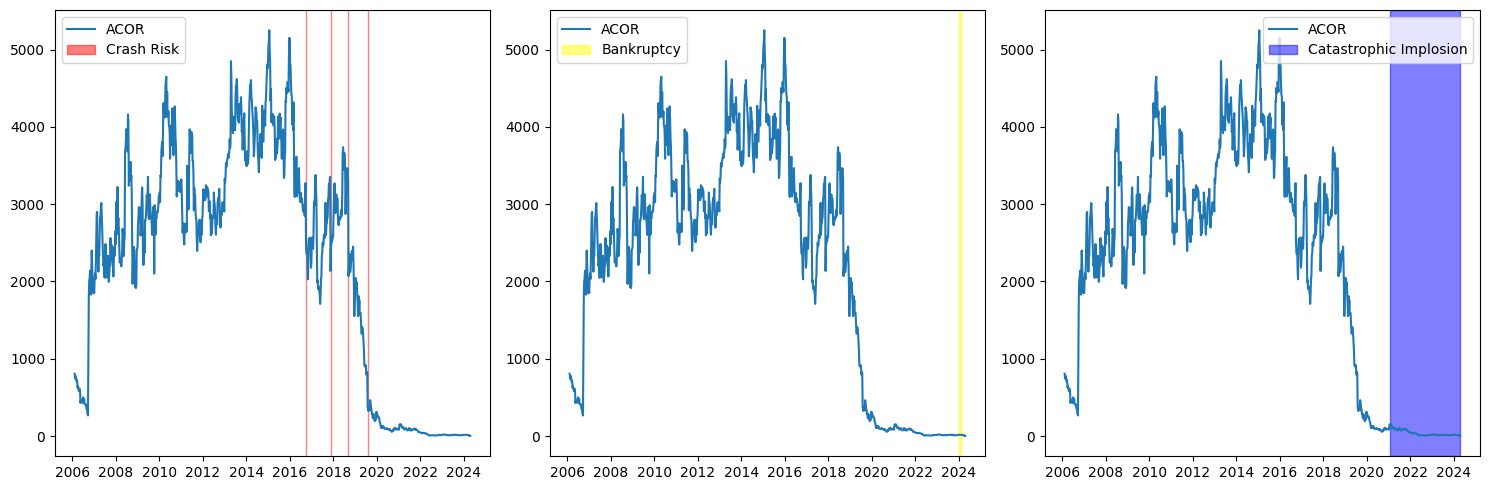

In [5]:
stock_series = get_stock_price('ACOR')
imp_dates2 = find_implosion_final(stock_series, -0.8, 78, 0.0)
# imp_dates3 = get_implosion_dates_crash(stock_series, 0, 104, 0.1, t)
imp_dates1 = stock_crash_risk(stock_series, 0, 0, 0, 'ACOR')

plot_acor(stock_series,imp_dates1, imp_dates2, [((pd.to_datetime('01-04-2024'), pd.to_datetime('02-04-2024')))] )

### ADTX eg

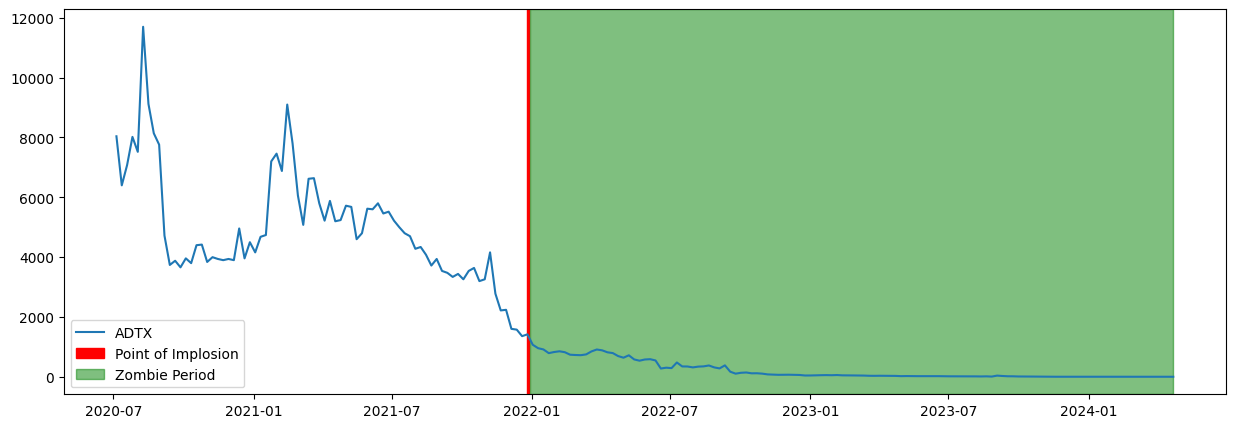

In [9]:
stock_series = get_stock_price('ADTX')
imp_dates1 = get_implosion_dates_dd(stock_series, -0.2, 104, 0.1, 'ADTX')
imp_dates2 = find_implosion_final(stock_series, -0.8, 78, -0.2)
# imp_dates3 = get_implosion_dates_crash(stock_series, 0, 104, 0.1, t)
imp_dates4 = stock_crash_risk(stock_series, 0, 0, 0, 'ADTX')
bankruptcy_date = [((pd.to_datetime('01-04-2024'), pd.to_datetime('02-04-2024')))]
plot_implosions_with_zombie(stock_series, imp_dates2, 'ADTX')

### CAPR eg

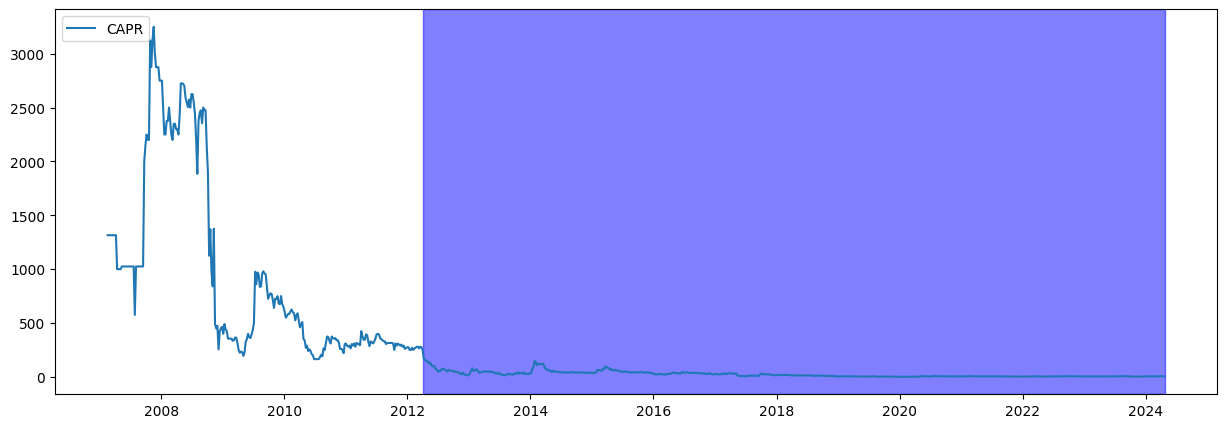

In [10]:
stock_series = get_stock_price('CAPR')
imp_dates2 = find_implosion_final(stock_series, -0.8, 78, -0.2)
plot_implosions(stock_series, imp_dates2, 'CAPR')

### 3-way Comparison of Methods

In [ ]:
import math


for t in imploded_stocks:
    stock_series = get_stock_price(t)
    if stock_series is None:
        continue
    if max(stock_series) < 100:
        continue
    if stock_series is not None:
        imp_dates1 = get_implosion_dates_dd(stock_series, -0.4, 78, 0.1, t)
        imp_dates2 = find_implosion_final(stock_series, -0.6, 78, -0.0)
        # imp_dates3 = get_implosion_dates_crash(stock_series, 0, 104, 0.1, t)
        imp_dates3 = stock_crash_risk_implosion(stock_series, None, 78, -0.2, t)
        plot_implosions_side_by_side(stock_series, imp_dates2, imp_dates1, imp_dates3, imp_dates3, t)

Alternative definition - look for point where 50-day moving average moves below 200-day moving average - check 12 months later for 80% drop - check 12 months no 40% rise? Upon results, there are suprisingly many stocks where this occurs, but crashes rarely follow

In [ ]:
#Some experimentation with Ruptures package

# import numpy as np
# import ruptures as rpt
# import matplotlib.pyplot as plt

# # Assuming get_stock_price('AAPL') returns a pandas Series of stock prices
# appl_price_series = get_stock_price('ACHV')

# # Convert the pandas Series to a numpy array
# appl_price = appl_price_series.values

# # Specify the changepoint detection method
# model = "l2"  
# algo = rpt.Binseg(model=model).fit(appl_price)
# my_bkps = algo.predict(n_bkps=1)
# # show results
# rpt.show.display(appl_price, my_bkps, figsize=(10, 6))
# plt.title('Change Point Detection: Binary Segmentation Search Method')
# plt.show()


# # change point detection
# model = "l1"  # "l2", "rbf"
# algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(appl_price)
# my_bkps = algo.predict(n_bkps=1)

# # show results
# rpt.show.display(appl_price,  my_bkps, figsize=(10, 6))
# plt.show()